## In this notebook we will be building an optimized network for binary classification.
- Incorporating regularization and dropout techniques in order to generalize the model's prediction.
- The data has two features feature1 and feature2 and one targer variable which is a binary value

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import tensorflow as tf

In [2]:
df = pd.read_csv("blobs.csv")
print(df.head())

   feature1  feature2  target
0  1.459110 -0.387450     1.0
1 -0.982582  0.431602     0.0
2  1.059435 -0.036946     0.0
3  0.314481  0.811808     0.0
4  1.017578  0.286717     0.0


In [3]:
X = df[['feature1', 'feature2']].values                     #extract feature1 and feature2 values
y = df['target'].values                                    #extract target values

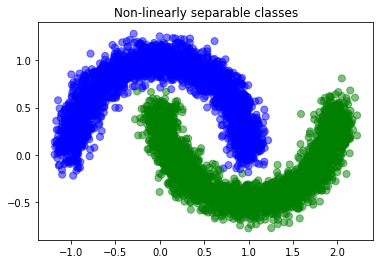

In [4]:
# - Visualize the data in x-y plane.
# - The blue spots corresponds to target value 0 and green spots corresponds to target value 1

colors=['blue','green']
cmap = matplotlib.colors.ListedColormap(colors)
#Plot the figure
plt.figure()
plt.title('Non-linearly separable classes')
plt.scatter(X[:,0], X[:,1], c=y, marker= 'o', s=50,cmap=cmap,alpha = 0.5 )
plt.show()

In [5]:
# - In order to feed the network the input has to be of **shape (number of features, number of samples)** 
#   and target should be of shape **(1, number of samples)**
# - Transpose X and assign it to variable 'X_data'
# - reshape y to have shape (1, number of samples) and assign to variable 'y_data'
X_data = X.T
y_data = y.reshape(1, len(y))

In [6]:
# Define the network dimension to have two input features, two hidden layers with 25 nodes each, one output node at final layer. 
layer_dims = [2, 25, 25, 1]

In [7]:
#  Function placeholders which return two placeholders one for input data as A_0 and one for output data as Y.
# - parameters - num_features
# - Returns - A_0 with shape (num_feature, None) and Y with shape(1,None)
def placeholders(num_features):
    A_0 = tf.placeholder(dtype = tf.float64, shape = ([num_features,None]))
    Y = tf.placeholder(dtype = tf.float64, shape = ([1,None])) 
    return A_0,Y

In [8]:
# Function initialize_parameters_deep() to initialize weights and bias for each layer
# - Parameters - layer_dims
# - Returns - dictionary of weights and bias
def initialize_parameters_deep(layer_dims):
    tf.set_random_seed(1)
    L = len(layer_dims)
    parameters = {}
    for l in range(1,L):
        parameters['W' + str(l)] = tf.get_variable("W" + str(l), shape=[layer_dims[l], layer_dims[l-1]], 
                                                    dtype = tf.float64,initializer=tf.contrib.layers.xavier_initializer())
                                  
        parameters['b' + str(l)] = tf.get_variable("b"+ str(l), shape = [layer_dims[l], 1], dtype = tf.float64, initializer = tf.zeros_initializer())
        
    return parameters

In [9]:
# Functon linear_forward_prop() to define forward propagation for a given layer.
# - parameters: A_prev(output from previous layer), W(weigth matrix of current layer), b(bias vector for current layer),activation(type of activation to be used for out of current layer)  
# - returns: A(output from the current layer)
# - Use relu activation for hidden layers and for final output layer return the output unactivated i.e if activation is sigmoid
def linear_forward_prop(A_prev,W,b, activation):
    Z = tf.add(tf.matmul(W, A_prev), b)
    if activation == "sigmoid":
        A = Z 
    elif activation == "relu":
        A = tf.nn.relu(Z) 
    return A

In [10]:
# Forward propagation for entire network as l_layer_forward()
# - Parameters: A_0(input data), parameters(dictionary of weights and bias), dropout (boolean)
# - returns: A(output from final layer)  
# If dropout = True, deactivate the layers's output with probability value equal to 0.8.  
# tensoflow's droupout function to apply dropout.
def l_layer_forwardProp(A_0, parameters, drop_out = False):
    A = A_0
    L = len(parameters)//2                               #number of layers
    for l in range(1,L):                                 
        A_prev = A
        A = linear_forward_prop(A_prev,parameters['W' + str(l)],parameters['b' + str(l)], "relu") #call linear_forward_prop to return the output from current layer
        if drop_out:                                    #check if dropout == True, if true apply dropout to current layer's output.
            A = tf.nn.dropout(x = A, keep_prob = 0.8)   #call tensoflow's droupout function to deactivate output A, set keep_prob = 0.8
    A = linear_forward_prop(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid" )   # return output from final layer.
    return A

In [17]:
# - Cost function
# - parameters:
#   - Z_final: output fro final layer
#   - Y: actual output
#   - parameters: dictionary of weigths and bias
#   - regularization : boolean
#   - lambd: regularization parameter
# - Define the original cost using tensoflow's sigmoid_cross_entropy function
# - If **regularization == True** add regularization term to original cost function
def final_cost(Z_final, Y , parameters, regularization = False, lambd = 0):
    #define original cost
    
    cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=Z_final,labels=Y)
    if regularization:
        #initialize regularization term to zero
        reg_term = 0                               
        L = len(parameters)//2                     
        for l in range(1,L+1):
            #use tensorflow's l2 regularization to calculate regularization term for each layer and
            #sum it up to previous layer's regularization term
            
            reg_term += tf.nn.l2_loss(parameters['W1']) + tf.nn.l2_loss(parameters['W2']) + tf.nn.l2_loss(parameters['W3']) 
        
        #multiply lambd/2 to reg_term to add it to original cost
        cost += reg_term * (lambd/2)
    return tf.reduce_mean(cost)

In [12]:
# - The model to train the network
# - parameters:
#   - X_train, Y_train: input and target data
#   - layer_dims: network configuration
#   - learning_rate
#   - num_iter: number of epoches
#   - regularization (boolean): If true apply regularization
#   - lambd: regularization parameter ($\lambda$)
#   - dropout (boolean): if true apply dropout
# - return: dictionary of trained parameters
def deep_net(X_train,Y_train, layer_dims, learning_rate, num_iter, regularization = False, lambd = 0, drop_out = False):
    tf.reset_default_graph()                
    num_features = layer_dims[0]
    A_0, Y = placeholders(num_features)                 #call placeholder function to initialize placeholders A_0 and Y
    parameters = initialize_parameters_deep(layer_dims) #Initialse Weights and bias using initialize_parameters_deep() with layer_dims as parameters  
    Z_final = l_layer_forwardProp(A_0, parameters)      #call the function l_layer_forwardProp() to define the final output
    
    # call final_cost() function to return the cost that has to be minimized during gradient descent
    cost = final_cost(Z_final, Y, parameters, regularization, lambd)
    
    #call tensorflow's gradient descent optimizer function with minimize cost  
    train_net = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)  
    init = tf.global_variables_initializer()
    costs = []
    with tf.Session() as sess:
        sess.run(init)
        for i in range(num_iter):
            _,c = sess.run([train_net, cost], feed_dict={A_0: X_train, Y: Y_train})
            if i % 100 == 0:
                costs.append(c)
            if i % 1000 == 0:
                print("Cost is :-> ",c)
        with open('output.txt', 'w') as file:
            file.write("cost = %f "  % costs[-1])
        plt.ylim(min(costs)+0.1 ,max(costs), 4, 0.01)
        plt.xlabel("epoches per 100")
        plt.ylabel("cost")
        plt.plot(costs)
        plt.show()
        params = sess.run(parameters)
    return params

In [13]:
# Define the function to predict output of the model for given input and parameters.
def predict(A_0, parameters):
    with tf.Session() as sess:
        Z = l_layer_forwardProp(A_0, parameters, drop_out= False)
        A = sess.run(tf.round(tf.sigmoid(Z)))
    return A

In [14]:
# - Define the function to plot the decision boundary.
def plot_decision_boundary1( X, y, model):
    plt.clf()
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1   
    colors=['blue','green']
    cmap = matplotlib.colors.ListedColormap(colors)   
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    A = model(np.c_[xx.ravel(), yy.ravel()])
    A = A.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, A, cmap="spring")
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, s=8,cmap=cmap)
    plt.title("Decision Boundary for learning rate:")
    plt.show()

Cost is :->  0.7132421643765888
Cost is :->  0.25878414407029326
Cost is :->  0.2219341121267459
Cost is :->  0.20050138185699642
Cost is :->  0.1708827679288826
Cost is :->  0.13036262403519908
Cost is :->  0.0894613565814543
Cost is :->  0.06020842942283915
Cost is :->  0.04255075315034038
Cost is :->  0.0321301056355035


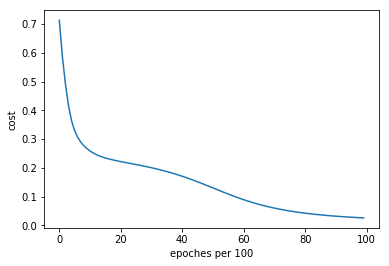

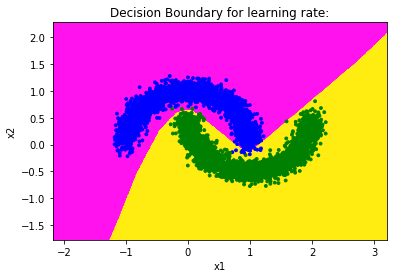

In [15]:
# Build the model with no dropout and regualrization,   
parameters = deep_net(X_data, y_data, layer_dims, learning_rate=0.01, num_iter=10000)
plot_decision_boundary1(X_data,y,lambda x: predict(x.T,parameters))

Cost is :->  1.2117813835597924
Cost is :->  0.6551921942537224
Cost is :->  0.5297090360837188
Cost is :->  0.46786964923924035
Cost is :->  0.4336253903753444
Cost is :->  0.4142239246537021
Cost is :->  0.40265769880402785
Cost is :->  0.3957891187328226
Cost is :->  0.39183313492595545
Cost is :->  0.3893556041024635


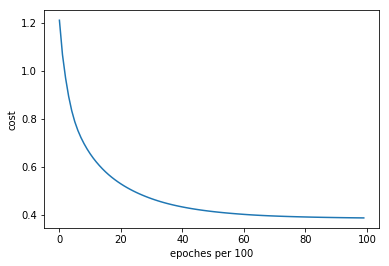

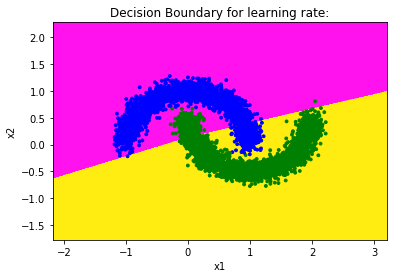

In [18]:
# If you are able to train the network and visualize the decision boundary you can see that model's prediction has defined the boundary
# Now build the model with regularization.  
parameters = deep_net(X_data, y_data, layer_dims, learning_rate=0.01, num_iter=10000, regularization=True, lambd=0.02)
plot_decision_boundary1(X_data,y,lambda x: predict(x.T,parameters))

Cost is :->  0.7132421643765888
Cost is :->  0.25878414407029326
Cost is :->  0.2219341121267459
Cost is :->  0.20050138185699642
Cost is :->  0.1708827679288826
Cost is :->  0.13036262403519908
Cost is :->  0.0894613565814543
Cost is :->  0.06020842942283915
Cost is :->  0.04255075315034038
Cost is :->  0.0321301056355035


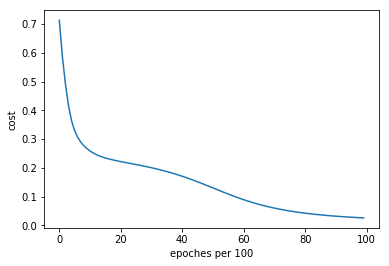

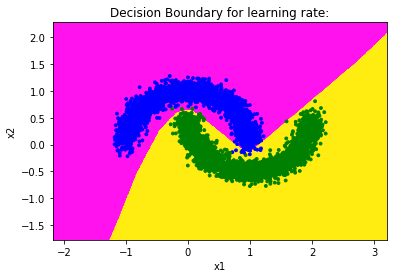

In [19]:
# Train the model with dropout  
parameters = deep_net(X_data, y_data, layer_dims, learning_rate=0.01, num_iter=10000, regularization=False, drop_out=True)
plot_decision_boundary1(X_data,y,lambda x: predict(x.T,parameters))